In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
# 构造正弦波和方波两类样本的函数 
def get_sequence_data(dimension=10, length=10,
                      number_of_examples=1000, train_set_ratio=0.7, seed=42):
    """
    生成两类序列数据。
    """
    xx = []

    # 正弦波
    xx.append(np.sin(np.arange(0, 10, 10 / length)).reshape(-1, 1))

    # 方波
    xx.append(np.array(signal.square(np.arange(0, 10, 10 / length))).reshape(-1, 1))
    
    
    data = []
    for i in range(2):
        x = xx[i]
        for j in range(number_of_examples // 2):
            sequence = x + np.random.normal(0, 0.6, (len(x), dimension))  # 加入噪声
            label = np.array([int(i == k) for k in range(2)])
            data.append(np.c_[sequence.reshape(1, -1), label.reshape(1, -1)])

    # 把各个类别的样本合在一起
    data = np.concatenate(data, axis=0)
    print(data[0].shape)

    # 随机打乱样本顺序
    np.random.shuffle(data)

    # 计算训练样本数量
    train_set_size = int(number_of_examples * train_set_ratio)  # 训练集样本数量
    plt.plot(np.arange(0,len(data[1,:-2])),data[1,:-2])

    # 将训练集和测试集、特征和标签分开
    return (data[:train_set_size, :-2].reshape(-1, length, dimension),
            data[:train_set_size, -2:],
            data[train_set_size:, :-2].reshape(-1, length, dimension),
            data[train_set_size:, -2:])

(1002,)


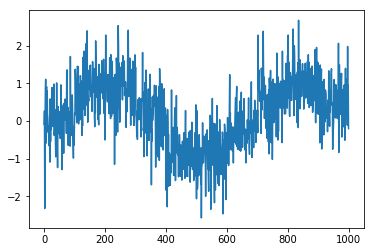

In [9]:
# 构造RNN
seq_len = 10  # 序列长度
dimension = 100  # 输入维度
status_dimension = 2  # 状态维度

signal_train, label_train, signal_test, label_test = get_sequence_data(length=seq_len, dimension=dimension)


In [10]:
import sys
sys.path.append('../')
import HuichuanFlow as hf

# 输入向量节点
inputs = [hf.core.Variable(dim=(dimension, 1), init=False, trainable=False) for i in range(seq_len)]
 
# 输入门
# 输入权值矩阵
U_i = hf.core.Variable(dim=(status_dimension, dimension), init=True, trainable=True)

# 状态权值矩阵
W_i = hf.core.Variable(dim=(status_dimension, status_dimension), init=True, trainable=True)

# 偏置向量
b_i = hf.core.Variable(dim=(status_dimension, 1), init=True, trainable=True)


# 输出门
# 输入权值矩阵
U_o = hf.core.Variable(dim=(status_dimension, dimension), init=True, trainable=True)

# 状态权值矩阵
W_o = hf.core.Variable(dim=(status_dimension, status_dimension), init=True, trainable=True)

# 偏置向量
b_o = hf.core.Variable(dim=(status_dimension, 1), init=True, trainable=True)


# 遗忘门
# 输入权值矩阵
U_f = hf.core.Variable(dim=(status_dimension, dimension), init=True, trainable=True)

# 状态权值矩阵
W_f = hf.core.Variable(dim=(status_dimension, status_dimension), init=True, trainable=True)

# 偏置向量
b_f = hf.core.Variable(dim=(status_dimension, 1), init=True, trainable=True)




U_C = hf.core.Variable(dim=(status_dimension, dimension), init=True, trainable=True)
W_C =  hf.core.Variable(dim=(status_dimension, status_dimension), init=True, trainable=True)
b_C = hf.core.Variable(dim=(status_dimension, 1), init=True, trainable=True)


# 单元计算的定义
def lstm_cell(i, o, state):

    # 建立一个 LSTM 单元
    input_gate = hf.ops.Sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)

    return output_gate * tf.tanh(state), state

In [11]:
last_step = None  # 上一步的输出，第一步没有上一步，先将其置为 None
last_step_C = None
for iv in inputs:
    f = hf.ops.Add(hf.ops.MatMul(U_f, iv), b_f)
    o = hf.ops.Add(hf.ops.MatMul(U_o, iv), b_o)
    i = hf.ops.Add(hf.ops.MatMul(U_i, iv), b_i)
    C_t = hf.ops.Add(hf.ops.MatMul(U_C,iv),b_C)

    if last_step is not None:
        f = hf.ops.Add(hf.ops.MatMul(W_f, last_step), f)
        o = hf.ops.Add(hf.ops.MatMul(W_o, last_step), o)
        i = hf.ops.Add(hf.ops.MatMul(W_i, last_step), i)
        C_t = hf.ops.Add(hf.ops.MatMul(W_C,last_step),C_t)
    f = hf.ops.Logistic(f)
    o = hf.ops.Logistic(o)
    i = hf.ops.Logistic(i)
    Ct = hf.ops.Multiply(i,C_t)
    if last_step_C is not None:
        Ct = hf.ops.Add(hf.ops.Multiply(f,last_step_C))
    Ct = hf.ops.ReLU(Ct)
    h = hf.ops.Multiply(o,Ct)
    last_step = h
    last_step_C = Ct

In [12]:
fc1 = hf.layer.fc(last_step, status_dimension, 10, "ReLU")  # 第一全连接层
# fc2 = hf.layer.fc(fc1, 10, 10, "ReLU")  # 第二全连接层
output = hf.layer.fc(fc1, 10, 2, "None")  # 输出层

In [13]:
# 概率
predict = hf.ops.Logistic(output)

# 训练标签
label = hf.core.Variable((2, 1), trainable=False)

# 交叉熵损失
loss = hf.ops.CrossEntropyWithSoftMax(output, label)

In [14]:
# 训练
learning_rate = 0.005
optimizer = hf.optimizer.Adam(hf.default_graph, loss, learning_rate)

batch_size = 20

for epoch in range(50):
    
    batch_count = 0   
    for i, s in enumerate(signal_train):
        
        # 将每个样本各时刻的向量赋给相应变量
        for j, x in enumerate(inputs):
            x.set_value(np.mat(s[j]).T)

        label.set_value(np.mat(label_train[i, :]).T)
        optimizer.one_step()
        
        batch_count += 1
        if batch_count >= batch_size:
            
            print("epoch: {:d}, iteration: {:d}, loss: {:.3f}".format(epoch + 1, i + 1, loss.value[0, 0]))

            
            optimizer.update()
            batch_count = 0
        

    pred = []
    for i, s in enumerate(signal_test):
                
        # 将每个样本各时刻的向量赋给相应变量
        for j, x in enumerate(inputs):
            x.set_value(np.mat(s[j]).T)

        predict.forward()
        pred.append(predict.value.A.ravel())
            
    pred = np.array(pred).argmax(axis=1)
    true = label_test.argmax(axis=1)
    
    accuracy = (true == pred).astype(np.int).sum() / len(signal_test)
    print("epoch: {:d}, accuracy: {:.5f}".format(epoch + 1, accuracy))

epoch: 1, iteration: 20, loss: 0.694
epoch: 1, iteration: 40, loss: 0.689
epoch: 1, iteration: 60, loss: 0.702
epoch: 1, iteration: 80, loss: 0.706
epoch: 1, iteration: 100, loss: 0.678
epoch: 1, iteration: 120, loss: 0.711
epoch: 1, iteration: 140, loss: 0.673
epoch: 1, iteration: 160, loss: 0.716
epoch: 1, iteration: 180, loss: 0.717
epoch: 1, iteration: 200, loss: 0.668
epoch: 1, iteration: 220, loss: 0.720
epoch: 1, iteration: 240, loss: 0.665
epoch: 1, iteration: 260, loss: 0.723
epoch: 1, iteration: 280, loss: 0.723
epoch: 1, iteration: 300, loss: 0.723
epoch: 1, iteration: 320, loss: 0.664
epoch: 1, iteration: 340, loss: 0.664
epoch: 1, iteration: 360, loss: 0.665
epoch: 1, iteration: 380, loss: 0.722
epoch: 1, iteration: 400, loss: 0.722
epoch: 1, iteration: 420, loss: 0.721
epoch: 1, iteration: 440, loss: 0.668
epoch: 1, iteration: 460, loss: 0.719
epoch: 1, iteration: 480, loss: 0.718
epoch: 1, iteration: 500, loss: 0.669
epoch: 1, iteration: 520, loss: 0.669
epoch: 1, iterat

KeyboardInterrupt: 